In [ ]:
# conda install -c conda-forge lightgbm
# conda install -c conda-forge xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 1. 결측치 제거
#### 1) 주택소유상태

주택소유상태에서 'ANY'는 단 하나 밖에 없는 값이므로

해당 row를 제거

In [2]:
df = pd.read_csv('train.csv')

df = df.drop(index=df[df['주택소유상태'] == 'ANY'].index)

In [3]:
df['대출기간'] = df['대출기간'].str.strip()
df['대출기간'] = df['대출기간'].str.split(' ', expand=True)[0]
df['대출기간'] = df['대출기간'].astype(int)

#### 2) 근로기간
#### (1) 단순 대치

근로기간이 'Unknown'인 것과

다른 데이터 분포가 가장 유사한 근로기간을 찾아서 대치

SSE를 구해서 가장 작은 값으로 대치 => 5년

In [4]:
df_un = df[df['근로기간'] == 'Unknown']
df_n = df[df['근로기간'] != 'Unknown']

In [5]:
def year_encoder(x):
    # 값이 이미 정수형인 경우 변환 없이 그대로 반환합니다.
    if isinstance(x, int):
        return x
    
    output = x.replace('years', '')
    output = output.replace('year', '')
    output = output.replace('+', '')
    
    # 공백이 있는 경우 첫 번째 값을 사용합니다.
    output = output.split()[0]
    
    # '<' 문자열이 포함된 경우에만 '0'으로 바꿉니다.
    if '<' in output:
        output = output.replace('<', '0')
    else:
        output = output.replace('Unknown', '-1')
    
    output = output.strip()
    output = int(output)

    return output

df_n['근로기간'] = df_n['근로기간'].apply(year_encoder)
df_un['근로기간'] = df_un['근로기간'].apply(year_encoder)


In [6]:
work_year = list(df_n['근로기간'].unique())
work_year = sorted(work_year)
work_year

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [7]:
numeric_col = ['대출기간','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '근로기간']
category_col = [ '주택소유상태', '대출목적']

In [8]:
un_income = df_un['연간소득'].value_counts(normalize=True).sort_index()

un_feature = [un_income]

In [9]:
un_income = df_un['연간소득'].mean()

sses = []

for year in work_year:
    sse = 0
    
    temp = df_n[df_n['근로기간'] == year]
    
    feature = temp['연간소득']
    data = (feature.value_counts() / feature.value_counts().values.sum()).sort_index()
        
    error = data - un_income
        
    se = error ** 2
        
    sse = se.values.sum()
    
    sses.append((year, sse))

print("SSE for each work year:")
for year, sse in sses:
    print(f'{year} year SSE : {sse}')
    

SSE for each work year:
0 year SSE : 3.283918998993168e+18
1 year SSE : 3.1016815406627615e+18
2 year SSE : 3.9800660898153175e+18
3 year SSE : 3.509893447322872e+18
4 year SSE : 3.076168296496505e+18
5 year SSE : 2.897575587332708e+18
6 year SSE : 2.452916189006517e+18
7 year SSE : 2.4747846840061665e+18
8 year SSE : 2.631508898170316e+18
9 year SSE : 2.401889700674004e+18
10 year SSE : 1.1998514256353171e+19


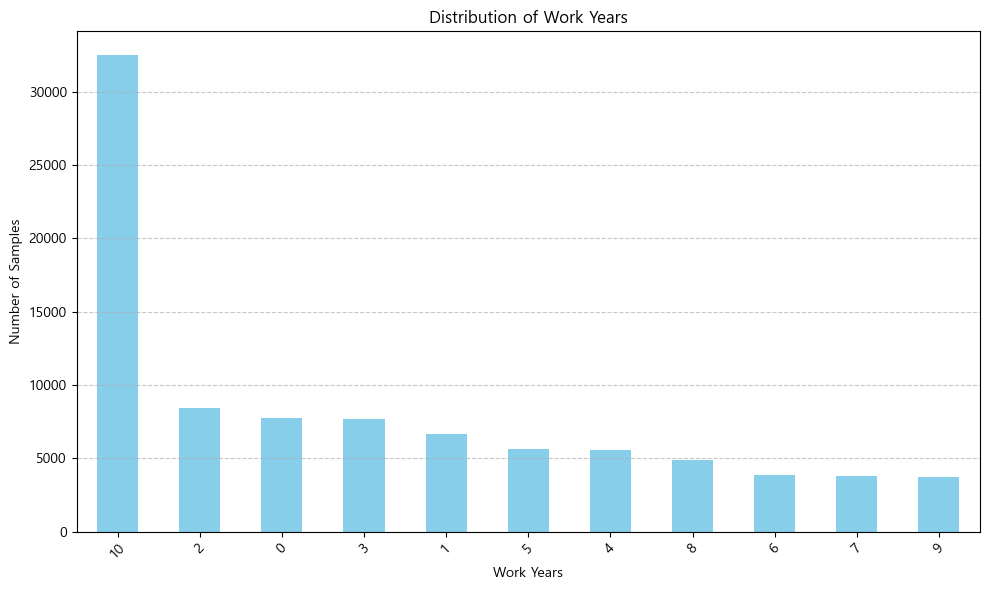

In [10]:
work_year_counts = df_n['근로기간'].value_counts()

# 시각화합니다.
plt.figure(figsize=(10, 6))
work_year_counts.plot(kind='bar', color=['skyblue' if year != '10' else 'salmon' for year in work_year_counts.index])
plt.title('Distribution of Work Years')
plt.xlabel('Work Years')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 회귀모델

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_n_encoded = pd.get_dummies(df_n[['주택소유상태', '대출목적']])
X = pd.concat([df_n_encoded, df_n['연간소득']], axis=1)  
y = df_n['근로기간'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

df_un_encoded = pd.get_dummies(df_un[['주택소유상태', '대출목적']])
df_un_features = pd.concat([df_un_encoded, df_un['연간소득']], axis=1) 

predicted_work_years = model.predict(df_un_features)
df_un['예측된_근로기간'] = predicted_work_years

print("Unknown 값을 대체한 데이터:")
print(df_un)

Mean Squared Error: 13.298175441791352
Unknown 값을 대체한 데이터:
                ID      대출금액  대출기간      근로기간    주택소유상태      연간소득  부채_대비_소득_비율  \
4      TRAIN_00004  18000000    60  5.467192      RENT  71736000        25.39   
14     TRAIN_00014   4320000    36  5.694410       OWN  18000000        16.00   
18     TRAIN_00018  12000000    36  6.636013  MORTGAGE  25200000        36.57   
19     TRAIN_00019  15900000    36  4.452898      RENT  41858400        18.34   
20     TRAIN_00020   4200000    36  5.993908  MORTGAGE  96000000         7.23   
...            ...       ...   ...       ...       ...       ...          ...   
96217  TRAIN_96217  31800000    36  4.970788      RENT  79200000        13.16   
96241  TRAIN_96241  11130000    36  5.979871       OWN  34800000         7.24   
96243  TRAIN_96243  15000000    60  6.105907       OWN  84000000        25.73   
96267  TRAIN_96267   8400000    36  6.466375  MORTGAGE  69600000        18.73   
96288  TRAIN_96288  21150000    36  7.127980  MORT

### 이상치 제거법

#### 1) 사분위수 - 유실 데이터가 너무 많아서 기각
#### 2) EDS 사용하기

In [ ]:
numeric_col = ['대출기간','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '근로기간']
category_col = [ '주택소유상태', '대출목적']



In [ ]:
def get_3_hist(data:pd.DataFrame, columns:list):
    
    plt.figure(figsize=(8, 8))

    for i, col in enumerate(columns):
        # 서브플롯 위치 설정
        plt.subplot(3, 4, i + 1)
        # 히스토그램 그리기
        sns.histplot(data[col])
        plt.title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

get_3_hist(df_simple, numeric_col)

In [ ]:
def get_3_box(data:pd.DataFrame, columns:list):
    
    plt.figure(figsize=(8, 8))

    for i, col in enumerate(columns):
        # 서브플롯 위치 설정
        plt.subplot(3, 4, i + 1)
        # 히스토그램 그리기
        sns.boxplot(data[col])
        plt.title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

get_3_box(df_simple, numeric_col)

In [ ]:
def remove_outliers(train_df, col, threshold=3):
    mean = np.mean(train_df[col])
    std_dev = np.std(train_df[col])
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    train_df= train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]
    return train_df

for col in numeric_col:
    df_simple = remove_outliers(df_simple, col, threshold=3)

In [ ]:
log_processing = ['최근_2년간_연체_횟수', '총연체금액']

for col in log_processing:
    df_simple[col] = np.log1p(df_simple[col])

In [ ]:
get_3_hist(df_simple, numeric_col)

In [ ]:
get_3_box(df_simple, numeric_col)

### 3. 인코딩, 스케일링

#### 1) 스캐일링

numeric_col 컬럼 중에서 히스토그램의 개형을 토대로

sc_col = ['최근_2년간_연체_횟수', '총연체금액', '연체계좌수']

mm_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '근로기간']

위와 같이 스캐일링 방법을 정함


In [ ]:
df = df_simple

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

print(X.shape, y.shape)

In [ ]:
def numeric_scaler(X):
    
    sc_col = ['최근_2년간_연체_횟수', '총연체금액', '연체계좌수']
    mm_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '근로기간']
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    sc = StandardScaler()
    mm = MinMaxScaler()
    
    X[sc_col] = sc.fit_transform(X[sc_col])
    X[mm_col] = mm.fit_transform(X[mm_col])
    
    return X

X = numeric_scaler(X)

In [ ]:
get_3_hist(X, numeric_col)

In [ ]:
get_3_box(X, numeric_col)

#### 2) 인코딩

category_col = ['대출기간', '주택소유상태', '대출목적'] 에서

우위를 따질 컬럼은 없어 보이기에 onehot 인코딩으로 통일

종속변수 y, 대출등급은 Label 인코딩을 사용

In [ ]:
def category_encoder(X:pd.DataFrame):
     X_dummies = pd.get_dummies(X[category_col])
     
     X = pd.concat([X, X_dummies], axis=1)
     
     return X, X_dummies.columns.to_list()

X, dummies_col = category_encoder(X)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])

### 4. 파생변수 만들기

대출등급이 높을수록 아래 요소들의 비중이 높아졌다

특히 대출 기간은 최하등급에서는 단기보다 장기의 비율이 더 높았다

이를 토대로 파생변수 제작 시 대출기간 컬럼의 비중을 높일 예정

- 대출기간 : 단기
- 주택상태 : 전세
- 대출목적 : 부채통합

In [ ]:
## 예시

for col in category_col:
    print(col)
    display(df[df['대출등급'] == "A"][col].value_counts() / df[df['대출등급'] == "A"][col].value_counts().sum())
    print('----------------------------------')


### 5. 오버샘플링

확인 결과 대출 등급이 낮은 데이터가 현저히 적다

오버샘플링을 통해 보완한다

오버샘플링을 위해 인코딩 먼저 하고 스캐일링을 진행

이후 파생변수를 생성한다

In [ ]:
X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

In [ ]:
y.value_counts()

In [ ]:
X, dummies_col = category_encoder(X)
X = X.drop(columns=category_col)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)

In [ ]:
y.value_counts()

In [ ]:
X = numeric_scaler(X)

In [ ]:
X.columns

In [ ]:
X['dv_category'] = ((2 * X['대출기간_ 36 months']) + X['주택소유상태_MORTGAGE'] + X['대출목적_부채 통합']) / 4
X['dv_ratio'] = X['총상환원금'] + 1 / X['대출금액'] + 1
X['dv_short_ability'] = (X['연간소득'] / 12) - (X['대출금액'] / 36)
X['dv_left_debt'] = X['대출금액'] - X['총상환원금'] - X['총상환이자']

In [ ]:
dummies_col = dummies_col + ['dv']
numeric_col = numeric_col + ['dv_ratio', 'dv_short_ability', 'dv_left_debt']

In [ ]:
X = X.replace([np.nan, np.inf, -np.inf], 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 6. 모델링

여러 모델을 돌려보고 점수 잘 나오는 모델로 선정

In [ ]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list):
    
    X_train = train 
    X_test = test

    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from sklearn.metrics import f1_score, accuracy_score
    
    logit = LogisticRegression()
    decision = DecisionTreeClassifier(random_state=42)
    rfc = RandomForestClassifier(random_state=42)
    gbc = GradientBoostingClassifier(random_state=42)
    xgb = XGBClassifier(random_state=42)
    light = LGBMClassifier(random_state=42)
    
    logit.fit(X_train, y_train)
    decision.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    gbc.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    light.fit(X_train, y_train)
    
    y_pred_train = logit.predict(X_train)
    y_pred_test = logit.predict(X_test)
    
    result_logit = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = decision.predict(X_train)
    y_pred_test = decision.predict(X_test)
    
    result_decision = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = rfc.predict(X_train)
    y_pred_test = rfc.predict(X_test)
    
    result_rfc = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = gbc.predict(X_train)
    y_pred_test = gbc.predict(X_test)
    
    result_gbc = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    
    result_xgb = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = light.predict(X_train)
    y_pred_test = light.predict(X_test)
    
    result_light = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    print('로지스틱')
    display(result_logit.round(2))
    print()
    print('의사결정나무')
    display(result_decision.round(2))
    print()
    print('랜덤포레스트')
    display(result_rfc.round(2))
    print()
    print('그라디언트 부스팅')
    display(result_gbc.round(2))
    print()
    print('XG 부스팅')
    display(result_xgb.round(2))
    print()
    print('Light GBM')
    display(result_light.round(2))


In [ ]:
# get_score(X_train, X_val, dummies_col + numeric_col)

#### 돌려본 결과 XGBOOST로 결정

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
    
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
    
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
    
result_xgb = pd.DataFrame(data={'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val)],
                                'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_val, average='macro')]},
                          index=['train','test'])
    
display(result_xgb.round(2))

### 7. 평가

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val, y_pred_val)
confusion

#### 1) 성능

heatmap에서 확인한 결과 중위권 등급 색이 옅음 - 중위권 등급을 잘 분류하지 못 함

In [ ]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.heatmap(confusion, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### 2) 중요도

- shap value는 다중분류에서 사용하는 법을 찾는 중
- feature importances를 통해 각 컬럼의 중요도를 산출

In [ ]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

In [ ]:
feat_imp = xgb.feature_importances_.flatten()

In [ ]:
feat_imp

In [ ]:
result = pd.DataFrame(data=feat_imp, index=X_train.columns, columns=['feat_imps'])

In [ ]:
result = pd.DataFrame(result['feat_imps'].sort_values(ascending=False))

In [ ]:
result

In [ ]:
sns.barplot(data=result, x='feat_imps', y=result.index, orient='h')
plt.xticks(rotation=90)